In [14]:
%load_ext autoreload
%autoreload 2
from sympy import symbols, init_printing, simplify, solve, srepr, Add, Symbol, Integer, Float, pi, cos, sin, Rational
from sympy import IndexedBase, Eq, simplify,sqrt
from grid import *
init_printing()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
Txx = Field('Txx', (False,False,False))
Tyy = Field('Tyy', (False,False,False))
Tzz = Field('Tzz', (False,False,False))
Txy = Field('Txy', (True,True,False))
Tyz = Field('Tyz', (False,True,True))
Txz = Field('Txz', (True,False,True))
U = Field('U', (True,False,False))
V = Field('V', (False,True,False))
W = Field('W', (False,False,True))

In [16]:
grid = StaggeredGrid3D('h h h','dt','dimx dimy dimz')
grid.set_stress_fields([Txx,Tyy,Tzz,Txy,Tyz,Txz])
grid.set_velocity_fields([U,V,W])

####Analytical solutions
$U = cos(\pi x)(sin(\pi y)-sin(\pi z))cos(\Omega t)$<br>
$V = cos(\pi y)(sin(\pi z)-sin(\pi x))cos(\Omega t)$<br>
$W = cos(\pi z)(sin(\pi x)-sin(\pi y))cos(\Omega t)$<br>
$T_{xx} = -Asin(\pi x)(sin(\pi y)-sin(\pi z))sin(\Omega t)$<br>
$T_{yy} = -Asin(\pi y)(sin(\pi z)-sin(\pi x))sin(\Omega t)$<br>
$T_{zz} = -Asin(\pi z)(sin(\pi x)-sin(\pi y))sin(\Omega t)$<br>
$T_{xy} = T_{yz} = T_{xz} = 0$<br>
where $A=\sqrt{2\rho \mu} \space \space b=\pi\sqrt{\frac{2\mu}{\rho}}$

In [17]:
rho, beta, lam, mu, h, dt= symbols('rho beta lam mu h dt')
x,y,z,t = symbols('x y z t')
Omega = pi*sqrt(2*mu/rho)
A = sqrt(2*rho*mu)
U_func = cos(pi*x)*(sin(pi*y)-sin(pi*z))*cos(Omega*t)
V_func = cos(pi*y)*(sin(pi*z)-sin(pi*x))*cos(Omega*t)
W_func = cos(pi*z)*(sin(pi*x)-sin(pi*y))*cos(Omega*t)
Txx_func = -A*sin(pi*x)*(sin(pi*y)-sin(pi*z))*sin(Omega*t)
Tyy_func = -A*sin(pi*y)*(sin(pi*z)-sin(pi*x))*sin(Omega*t)
Tzz_func = -A*sin(pi*z)*(sin(pi*x)-sin(pi*y))*sin(Omega*t)
Txy_func = Float(0)
Tyz_func = Float(0)
Txz_func = Float(0)

In [18]:
U.set_analytic_func(U_func)
V.set_analytic_func(V_func)
W.set_analytic_func(W_func)
Txx.set_analytic_func(Txx_func)
Tyy.set_analytic_func(Tyy_func)
Tzz.set_analytic_func(Tzz_func)
Txy.set_analytic_func(Txy_func)
Tyz.set_analytic_func(Tyz_func)
Txz.set_analytic_func(Txz_func)

In [19]:
grid.calc_derivatives()

###PDEs
#####momentum equations
$\partial_tU = b(\partial_xT_{xx}+\partial_yT_{xy}+\partial_zT_{xz})$<br>
$\partial_tV = b(\partial_xT_{xy}+\partial_yT_{yy}+\partial_zT_{yz})$<br>
$\partial_tW = b(\partial_xT_{xz}+\partial_yT_{yz}+\partial_zT_{zz})$<br>
#####stress-strain equations
$\partial_tT_{xx} = (\lambda+2\mu)\partial_xU + \lambda(\partial_yV+\partial_zW)$<br>
$\partial_tT_{yy} = (\lambda+2\mu)\partial_yV + \lambda(\partial_xU+\partial_zW)$<br>
$\partial_tT_{zz} = (\lambda+2\mu)\partial_zW + \lambda(\partial_xU+\partial_yV)$<br>
$\partial_tT_{xy} = \mu(\partial_yU + \partial_xV)$<br>
$\partial_tT_{xz} = \mu(\partial_zU + \partial_xW)$<br>
$\partial_tT_{yz} = \mu(\partial_zV + \partial_yW)$<br>

In [20]:
# momentum equations
eq1 = Eq(U.d[0][1], beta*(Txx.d[1][2] + Txy.d[2][2] + Txz.d[3][2]))
eq2 = Eq(V.d[0][1], beta*(Txy.d[1][2] + Tyy.d[2][2] + Tyz.d[3][2]))
eq3 = Eq(W.d[0][1], beta*(Txz.d[1][2] + Tyz.d[2][2] + Tzz.d[3][2]))
# stress-strain equations
eq4 = Eq(Txx.d[0][1], (lam + 2*mu)*U.d[1][2] + lam*(V.d[2][2]+W.d[3][2]))
eq5 = Eq(Tyy.d[0][1], (lam + 2*mu)*V.d[2][2] + lam*(U.d[1][2]+W.d[3][2]))
eq6 = Eq(Tzz.d[0][1], (lam + 2*mu)*W.d[3][2] + lam*(U.d[1][2]+V.d[2][2]))
eq7 = Eq(Txy.d[0][1], mu*(U.d[2][2] + V.d[1][2]))
eq8 = Eq(Tyz.d[0][1], mu*(V.d[3][2] + W.d[2][2]))
eq9 = Eq(Txz.d[0][1], mu*(U.d[3][2] + W.d[1][2]))

In [22]:
grid.solve_fd([eq1,eq2,eq3,eq4,eq5,eq6,eq7,eq8,eq9])

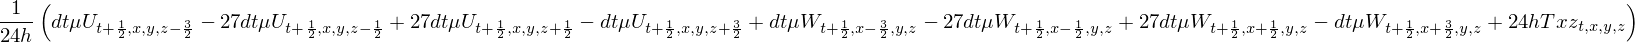

In [26]:
Txz.fd

In [9]:
Txx.d

[[None,
  -Txx[t - 1/2, x, y, z]/dt + Txx[t + 1/2, x, y, z]/dt,
  Txx[t - 3/2, x, y, z]/(24*dt) - 9*Txx[t - 1/2, x, y, z]/(8*dt) + 9*Txx[t + 1/2, x, y, z]/(8*dt) - Txx[t + 3/2, x, y, z]/(24*dt),
  None],
 [None,
  -Txx[t, x - 1/2, y, z]/h + Txx[t, x + 1/2, y, z]/h,
  Txx[t, x - 3/2, y, z]/(24*h) - 9*Txx[t, x - 1/2, y, z]/(8*h) + 9*Txx[t, x + 1/2, y, z]/(8*h) - Txx[t, x + 3/2, y, z]/(24*h),
  None],
 [None,
  -Txx[t, x, y - 1/2, z]/h + Txx[t, x, y + 1/2, z]/h,
  Txx[t, x, y - 3/2, z]/(24*h) - 9*Txx[t, x, y - 1/2, z]/(8*h) + 9*Txx[t, x, y + 1/2, z]/(8*h) - Txx[t, x, y + 3/2, z]/(24*h),
  None],
 [None,
  -Txx[t, x, y, z - 1/2]/h + Txx[t, x, y, z + 1/2]/h,
  Txx[t, x, y, z - 3/2]/(24*h) - 9*Txx[t, x, y, z - 1/2]/(8*h) + 9*Txx[t, x, y, z + 1/2]/(8*h) - Txx[t, x, y, z + 3/2]/(24*h),
  None]]